This file analysis the data from WebChild

In [1]:
from util import *
import numpy as np
import random, os
import matplotlib.pyplot as plt

## Setup directories

In [2]:
# input_file
kgtk_webchild = "kgtk_webchild_comparative.tsv"

# ouput_file
wc_gold_10k_amb_file = "wc_gold_10k_amb_head.tsv"
partition_folder = "./head_clustering"
wc_train_10k ="./head_clustering/train_wc.tsv" 
wc_dev_10k ="./head_clustering/dev_wc.tsv" 
wc_test_10k ="./head_clustering/test_wc.tsv" 

## Generate 10K Ambiguous Head Gold Dataset

In [3]:
def distribution(wn_gold_all):
    # obtain the dsitribution of each label
    # output: {label1-> str: num->integer}
    distri = dict()
    for line in wn_gold_all:
        node1_label = line[0]

        node1_id = line[3]

        temp1 = distri.get(node1_label,set())
        temp1.add(node1_id)

        distri[node1_label] = temp1
    
    for item in distri:
        distri[item] = len(distri[item])
    return distri

def ambiguous_filter(lines,ambiguous_num = 1):
    # filter the labels based on their ambiguous number (multiple meanning) global file
    for line in lines:
        subject = line[0]
        
        candits = generate_candidates(subject)
        
        if len(candits)>1: #(multi meaning)
            yield line

def write_gold(filename, lines):
    # write prediction to file
    new_head = ['node1;label','relation','node2;label','node1','node2']
    with open(filename, "w", newline='',encoding="UTF-8") as f:
        writer = csv.writer(f, delimiter='\t')
        writer.writerow(new_head)
        writer.writerows(lines)

def generate_gold_file(lines):
    # Transfer line to head 'node1;label','relation','node2;label','node1','node2'
    wn_gold_all = []
    i = 0
    for line in lines:
        #change column to node1;label, relation, node2;label, node1, node2
        node1_id = line[0]
        relation = line[1]
        node2_id = line[2]
        node1_labels = line[3]
        node2_labels = line[4]
        
        sent = line[8].replace("[","").replace("]","")
        # modeify the node labels, check with leve distance

        node1_label = multiple_labels(node1_labels,node1_id)
        node2_label = multiple_labels(node2_labels,node2_id)

        wn_gold_all.append([node1_label, relation, node2_label, node1_id, node2_id,sent])
        i += 1
        if i%10000==1:
            print(f"\r {i}/{len(lines)}", end="")
        
    return wn_gold_all

In [4]:
# load kgtk file
head, lines = load_file(kgtk_webchild, encoding="latin1")

# transfer kgtk file to column to node1;label, relation, node2;label, node1, node2
wc_gold_all = generate_gold_file(lines)

 810001/812862

In [5]:
wc_gold_all[0]

['action',
 'wn:loud.a.01',
 'word',
 'wn:action.n.01',
 'wn:word.n.04',
 'action speak louder than word']

**write wc_gold_10k file**

In [6]:
print("total num of lines: ", len(wc_gold_all))

# check ambiguous of words in each line. Only ambiguous subject word (multiple meanning words) is record.
filtered_lines = list(ambiguous_filter(wc_gold_all))
print("total num of lines with multi ambiguous subject: ", len(filtered_lines))

# random choice 10000 lines
if len(filtered_lines) > 10000:
    wc_gold_10k = random.choices(filtered_lines, k=10000)
else:
    wc_gold_10k = filtered_lines

#write file
write_gold(wc_gold_10k_amb_file, wc_gold_10k)


total num of lines:  812862
total num of lines with multi ambiguous subject:  251506


**Split train, dev, test file**

In [7]:
# define ratio of train, dev, test
train_ratio = 0.8
dev_ratio = 0.1
test_ratio = 1 - train_ratio - dev_ratio

len_gold = len(wc_gold_10k)
train, dev, test = np.split(wc_gold_10k,[int(train_ratio*len_gold),int((train_ratio+dev_ratio)*len_gold)])
print("length of train, dev, test: ", len(train), len(dev), len(test))

# write to file

#generate folder
if not os.path.isdir(partition_folder):
    os.mkdir(partition_folder)

# write train file
write_gold(wc_train_10k, train)

# write dev file
write_gold(wc_dev_10k, dev)

#write test file
write_gold(wc_test_10k, test)

length of train, dev, test:  8000 1000 1000


**Distribution Analysis**

(array([2.774e+03, 0.000e+00, 0.000e+00, 1.280e+02, 0.000e+00, 0.000e+00,
        1.100e+01, 0.000e+00, 0.000e+00, 1.000e+00]),
 array([1. , 1.3, 1.6, 1.9, 2.2, 2.5, 2.8, 3.1, 3.4, 3.7, 4. ]),
 <BarContainer object of 10 artists>)

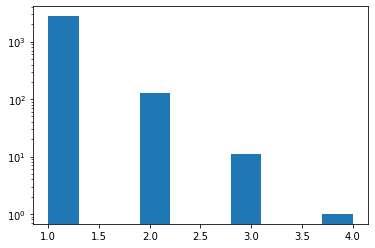

In [8]:
# train data distribution
distri_train = distribution(train)
plt.hist(distri_train.values(),log=True)

(array([704.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,  15.]),
 array([1. , 1.1, 1.2, 1.3, 1.4, 1.5, 1.6, 1.7, 1.8, 1.9, 2. ]),
 <BarContainer object of 10 artists>)

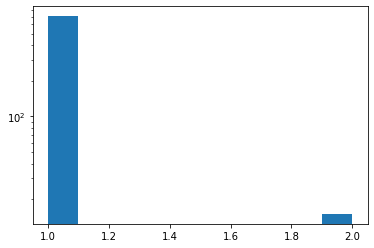

In [9]:
# dev data distribution
distri_dev = distribution(dev)
plt.hist(distri_dev.values(),log=True)

(array([700.,   0.,   0.,   0.,   0.,  10.,   0.,   0.,   0.,   1.]),
 array([1. , 1.2, 1.4, 1.6, 1.8, 2. , 2.2, 2.4, 2.6, 2.8, 3. ]),
 <BarContainer object of 10 artists>)

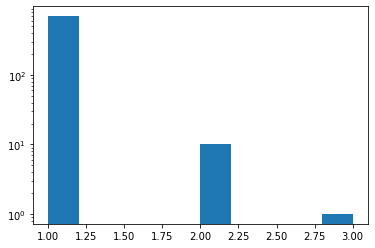

In [10]:
# test data distribution
distri_test = distribution(test)
plt.hist(distri_test.values(),log=True)

## Four baselines to predict (WebChild)
**Random, Frequency, STB model, STR model**

In [11]:
# prosible of missing subject
def missing_prob(lines):
    count = 0
    for line in lines:
        nodeLabel = line[0]

        if generate_candidates(nodeLabel):
            count +=1
            
    return count/len(lines)

In [12]:
print("probability of missing subject for train: ",missing_prob(train))
print("probability of missing subject for dev: ",missing_prob(dev))
print("probability of missing subject for test: ",missing_prob(test))

probability of missing subject for train:  1.0
probability of missing subject for dev:  1.0
probability of missing subject for test:  1.0


## Random Baseline (WebChild)

In [13]:
def MRS(wn_gold):
    # Random Baseline calculation
    # only predict subject
    wn_predict = []
    for line in wn_gold:
        label1  = line[0]
        label2 = line[2]
        relationship = line[1]
        
        # generate all possible combination of "_"&"-" and check whether it can find sysets.
        # if the combination can generate sysets, use this combinations to generate candidates
        candidates1 = generate_candidates(label1)
        
        if candidates1:
            # random choose candidates
            node1_id = random.choice(candidates1)
        else:
            node1_id = ""
        
        node2_id=""
        
        wn_predict.append([label1, relationship, label2, node1_id, node2_id])
        
    return wn_predict


def validation(wn_predict, wn_gold):
    # valid the accuracy of prediction: only compare the accuracy of subject
    
    correct = 0
    
    for predict, actual in zip(wn_predict, wn_gold):
        predict_label1 = synset2str(predict[3])
        actual_label1 = actual[3]
        
        if predict_label1 == actual_label1:
            # predict and actual is same
            correct += 1
            
    return correct/len(wn_predict)

**train dataset**

In [14]:
wn_ran_train_predict = MRS(train)
accuracy = validation(wn_ran_train_predict, train)
print("Accuracy of train dataset (random baseline): ", accuracy)

Accuracy of train dataset (random baseline):  0.20175


**dev dataset**

In [15]:
wn_ran_dev_predict = MRS(dev)
accuracy = validation(wn_ran_dev_predict, dev)
print("Accuracy of dev dataset (random baseline): ", accuracy)

Accuracy of dev dataset (random baseline):  0.187


**test dataset**

In [16]:
wn_ran_test_predict = MRS(test)
accuracy = validation(wn_ran_test_predict, test)
print("Accuracy of test dataset (random baseline): ", accuracy)

Accuracy of test dataset (random baseline):  0.188


## Frequency Baseline (WebChild)

In [17]:
def MFS(wn_gold):
    # Frequent Baseline Calculation
    wn_predict = []
    for line in wn_gold:
        label1  = line[0]
        label2 = line[2]
        relationship = line[1]
        
        # same as MRS, generate candidates
        candidates1 = generate_candidates(label1)
        
        # obtain the highest frequency
        if candidates1:
            node1_id = candidates1[0]
        else:
            node1_id = ""       

        node2_id = ""
        

        wn_predict.append([label1, relationship, label2, node1_id, node2_id])
        
    return wn_predict

**train dataset**

In [18]:
wn_fre_train_predict = MFS(train)
accuracy = validation(wn_fre_train_predict, train)
print("Accuracy of train dataset (random baseline): ", accuracy)

Accuracy of train dataset (random baseline):  0.789375


**dev dataset**

In [19]:
wn_fre_dev_predict = MFS(dev)
accuracy = validation(wn_fre_dev_predict, dev)
print("Accuracy of dev dataset (random baseline): ", accuracy)

Accuracy of dev dataset (random baseline):  0.784


**test dataset**

In [20]:
wn_fre_test_predict = MFS(test)
accuracy = validation(wn_fre_test_predict, test)
print("Accuracy of test dataset (random baseline): ", accuracy)

Accuracy of test dataset (random baseline):  0.8


## Sentence-Transformer-Bert (STB) (WebChild)

In [114]:
model_STB = SentenceTransformer('roberta-large-nli-stsb-mean-tokens')

In [115]:
def sentence_embedding(wn_gold, model, label_embeddings = None):
    # use sentences embedding to find most similar candit
    wn_predict = []
    sents_combine = []
    
    for line in wn_gold:
        sentence = line[5]
        sents_combine.append(sentence)
    # obtain sentence embedding
    sents_embedding = model.encode(sents_combine)
    
    
    for line,sent_embedding in zip(wn_gold,sents_embedding):
        label1 = line[0]

        #obtain the max similar item for label1
        node_id1 = max_candidate(label1,sent_embedding,label_embeddings) 
        node_id2 = ""
                
        wn_predict.append([label1, line[1], line[2],node_id1,node_id2])
        
    return wn_predict

**train dataset**

In [121]:
# obtain the defination embedding of each synset for each label
label_embeddings = candidates_embeddings(train, model_STB)

# obtain the predict
wn_STB_train_predict= sentence_embedding(train, model_STB,label_embeddings = label_embeddings)
# release cache
torch.cuda.empty_cache()
# Check the Accuracy
accuracy = validation(wn_STB_train_predict, train)
accuracy

0.25625

**dev dataset**

In [116]:
# obtain the defination embedding of each synset for each label
label_embeddings = candidates_embeddings(dev, model_STB)

# obtain the predict
wn_STB_dev_predict= sentence_embedding(dev, model_STB,label_embeddings = label_embeddings)

# Check the Accuracy
accuracy = validation(wn_STB_dev_predict, dev)
accuracy

0.256

**test dataset**

In [117]:
# obtain the defination embedding of each synset for each label
label_embeddings = candidates_embeddings(test, model_STB)

# obtain the predict
wn_STB_test_predict= sentence_embedding(test, model_STB,label_embeddings = label_embeddings)

# Check the Accuracy
accuracy = validation(wn_STB_test_predict, test)
accuracy

0.261

## Sentence-Transformer-Roberta (STR) (WebChild)

In [118]:
model_STR = SentenceTransformer('roberta-large-nli-stsb-mean-tokens')

**train dataset**

In [ ]:
# obtain the defination embedding of each synset for each label
label_embeddings = candidates_embeddings(train, model_STR)

# obtain the predict
wn_STR_train_predict= sentence_embedding(train, model_STR,label_embeddings = label_embeddings)
# release cache
torch.cuda.empty_cache()
# Check the Accuracy
accuracy = validation(wn_STR_train_predict, dev)
accuracy

**dev dataset**

In [119]:
# obtain the defination embedding of each synset for each label
label_embeddings = candidates_embeddings(dev, model_STR)

# obtain the predict
wn_STR_dev_predict= sentence_embedding(dev, model_STR,label_embeddings = label_embeddings)

# Check the Accuracy
accuracy = validation(wn_STR_dev_predict, dev)
accuracy

0.256

**test dataset**

In [120]:
# obtain the defination embedding of each synset for each label
label_embeddings = candidates_embeddings(test, model_STR)

# obtain the predict
wn_STR_test_predict= sentence_embedding(test, model_STR,label_embeddings = label_embeddings)

# Check the Accuracy
accuracy = validation(wn_STR_test_predict, test)
accuracy

0.261

## POS Baseline

Obtain the all relationship and design the limitation of relationship

In [59]:
def generate_idx_combine(len_nodeid1,len_nodeid2):
    # generate index combination for nodeId combination.
    # nodeId combination will be used to check whther the prediction limitation satisfied
    
    total = len_nodeid1 + len_nodeid2

    for i in range(total):
        for len1 in range(min(i+1,len_nodeid1)):
            len2 = i-len1
            if len2 < len_nodeid2:
                yield len1, len2

def relation_limit_sum(wc_gold):
    # summary the limitation of relation
    # 4 possible, POS same, POS differnt, node1 POS x is True
    # POS type for WordNet: ADJ, ADJ_SAT, ADV, NOUN, VERB = 'a', 's', 'r', 'n', 'v'
    
    # status = [same,different,label1_a,label1_s,label1_r,label1_n,label1_v
                #label2_a,label2_s,label2_r,label2_n,label2_v]
    status = tuple([True]*12)
    
    relation_status = dict()
    for line in wc_gold:
        relation = line[1]
        node1_id = line[3]
        node2_id = line[4]
        
        node1_POS = line[3].split(".")[1]
        node2_POS = line[4].split(".")[1]
        cur_status = relation_status.get(relation, list(status))
        
        # check same
        if cur_status[0]:
            if node1_POS!=node2_POS:
                cur_status[0] = False
                
        # check different
        if cur_status[1]:
            if node1_POS==node2_POS:
                cur_status[1] = False
                
        # check label1:
        pos_list = ["a","s","r","n","v"]
        for idx in range(len(pos_list)):
            if cur_status[2+idx]:
                if node1_POS != pos_list[idx]:
                    cur_status[2+idx] = False
                
        #check label2:
        for idx in range(len(pos_list)):
            if cur_status[7+idx]:
                if node2_POS != pos_list[idx]:
                    cur_status[7+idx] = False
                
        relation_status[relation] = cur_status
    
    #build word2limit:
    word2limit = dict()
    status_name = ["same","different","label1_a","label1_s","label1_r","label1_n","label1_v","label2_a",\
                   "label2_s","label2_r","label2_n","label2_v"]
    for relation in relation_status:
        limit = word2limit.get(relation,[])
        cur_status = relation_status[relation]
        
        for idx in range(len(cur_status)):
            single_status = cur_status[idx]
            
            if single_status:
                limit.append(status_name[idx])
                
        word2limit[relation]=limit
            
    return word2limit

def frequency_pos(wn_gold,word2limit):
    # Frequent Baseline Calculation
    wn_predict = []
    for line in wn_gold:
        label1  = line[0]
        label2 = line[2]
        relationship = line[1]
        
        # same as MRS, generate candidates
        candidates1 = generate_candidates(label1)
        candidates2 = generate_candidates(label2)
        
        node_id1 = ""
        for idx1, idx2 in generate_idx_combine(len(candidates1),len(candidates2)):
        # obtain the highest frequency
            node_id1 = candidates1[idx1]
            node_id2 = candidates2[idx2]
            
            status = predicate_limitation_check(node_id1, node_id2, relationship, word2limit)

            if status:
                break
            else:
                continue
        
        if not node_id1:
            node_id1 = candidates1[0]
        node_id2 = ""
        wn_predict.append([label1, relationship, label2, node_id1, node_id2])
        
    return wn_predict

In [60]:
word2limit = relation_limit_sum(wc_gold_all)

**train dataset**

In [61]:
# obtain the predict
wn_POS_train_predict= frequency_pos(train, word2limit)

# Check the Accuracy
accuracy = validation(wn_POS_train_predict, train)
accuracy

0.789125

**dev dataset**

In [62]:
# obtain the predict
wn_POS_dev_predict= frequency_pos(dev, word2limit)

# Check the Accuracy
accuracy = validation(wn_POS_dev_predict, dev)
accuracy

0.784

**test dataset**

In [63]:
# obtain the predict
wn_POS_test_predict= frequency_pos(test,word2limit)

# Check the Accuracy
accuracy = validation(wn_POS_test_predict, test)
accuracy

0.8